In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer



train_df = pd.read_csv('train.csv')

In [3]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

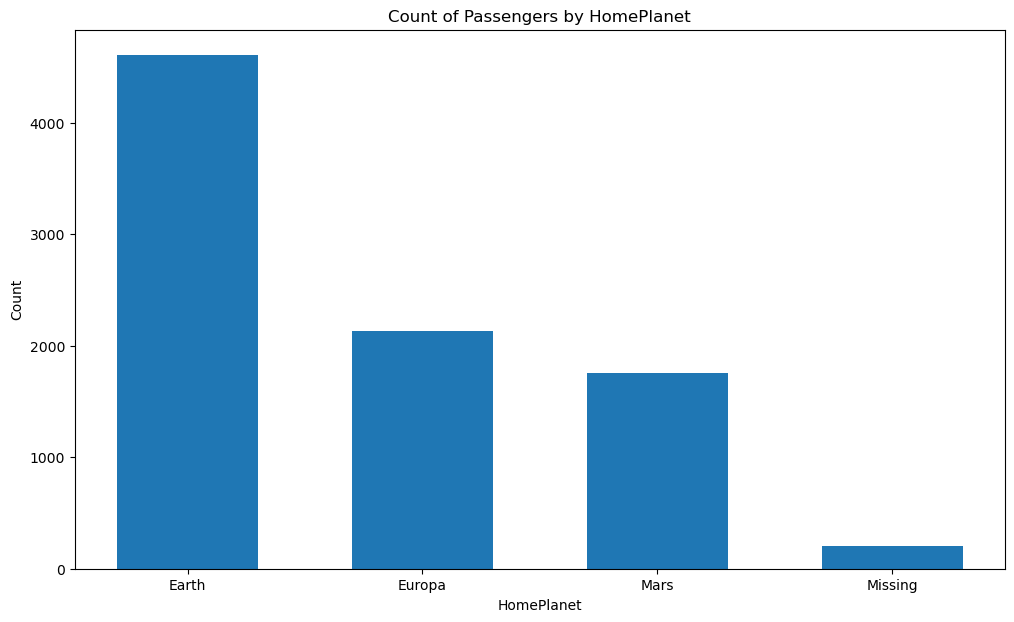

HomePlanet
Earth      0.529391
Europa     0.245140
Mars       0.202347
Missing    0.023122
Name: count, dtype: float64


In [58]:
plt.figure(figsize=(12,7))
counts = train_df['HomePlanet'].value_counts()
plt.bar(counts.index, counts.values, width=0.6)
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.title('Count of Passengers by HomePlanet')
plt.show()

print(counts/counts.sum())

HomePlanet
Europa     0.158846
Mars       0.023024
Missing    0.012438
Earth     -0.076054
dtype: float64


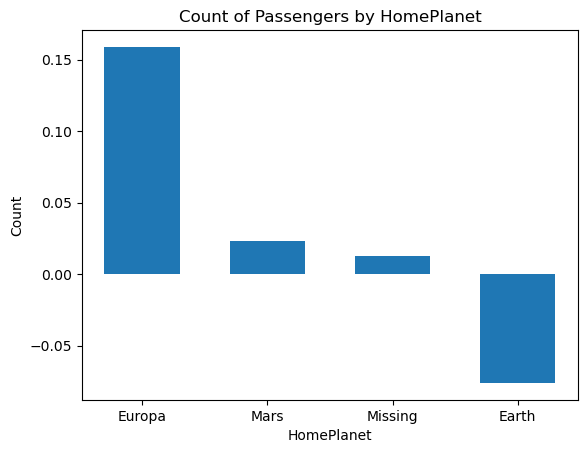

In [64]:
transported_true = train_df[train_df['Transported'] == True]
transported_counts = transported_true.groupby('HomePlanet').size()
percentages = transported_counts/counts
homeplanet_map = percentages.sort_values(ascending=False)
distance_from_random = homeplanet_map - 0.5
print(distance_from_random)
plt.bar(distance_from_random.index, distance_from_random.values, width=0.6)
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.title('Count of Passengers by HomePlanet')
plt.show()

Destination
55 Cancri e      0.110000
Missing          0.005495
PSO J318.5-22    0.003769
TRAPPIST-1e     -0.028825
dtype: float64


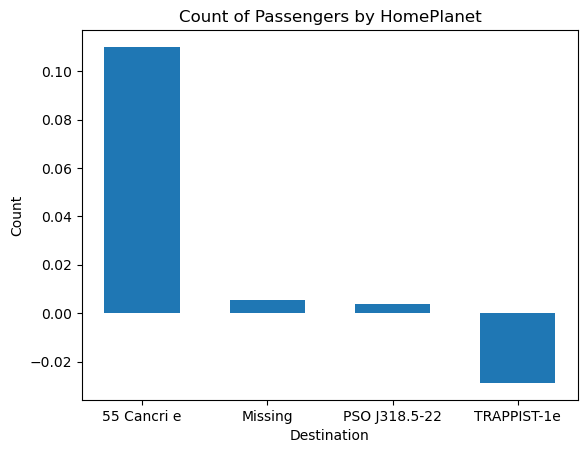

In [71]:
Destcounts = train_df['Destination'].value_counts()
transDest_counts = transported_true.groupby('Destination').size()
percent_vals = transDest_counts/Destcounts
dest_map = percent_vals.sort_values(ascending=False)
distance_from_rand = dest_map - 0.5
print(distance_from_rand)
plt.bar(distance_from_rand.index, distance_from_rand.values, width=0.6)
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by HomePlanet')
plt.show()

In [5]:
for col in train_df.columns:
    if col == 'PassengerId':
        continue  # skip ID column
    
    print(f"Value counts for column: {col}")
    counts = train_df[col].value_counts(dropna=False)  # include NaNs in counts if any
    proportions = counts / counts.sum()
    
    print(counts)
    print(proportions)
    print('-' * 40)

Value counts for column: HomePlanet
HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64
HomePlanet
Earth     0.529391
Europa    0.245140
Mars      0.202347
NaN       0.023122
Name: count, dtype: float64
----------------------------------------
Value counts for column: CryoSleep
CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64
CryoSleep
False    0.625676
True     0.349362
NaN      0.024963
Name: count, dtype: float64
----------------------------------------
Value counts for column: Cabin
Cabin
NaN        199
G/734/S      8
C/137/S      7
B/201/P      7
G/109/P      7
          ... 
G/556/P      1
E/231/S      1
G/545/S      1
G/543/S      1
C/178/S      1
Name: count, Length: 6561, dtype: int64
Cabin
NaN        0.022892
G/734/S    0.000920
C/137/S    0.000805
B/201/P    0.000805
G/109/P    0.000805
             ...   
G/556/P    0.000115
E/231/S    0.000115
G/545/S    0.000115
G/543/S    0.000115
C/178/S    0.0001

In [6]:
nulls = train_df.isnull().sum()
total = len(train_df)
print(pd.DataFrame({'nulls': nulls, 'total': total, 'percent_null': (nulls / total * 100)}))


              nulls  total  percent_null
PassengerId       0   8693      0.000000
HomePlanet      201   8693      2.312205
CryoSleep       217   8693      2.496261
Cabin           199   8693      2.289198
Destination     182   8693      2.093639
Age             179   8693      2.059128
VIP             203   8693      2.335212
RoomService     181   8693      2.082135
FoodCourt       183   8693      2.105142
ShoppingMall    208   8693      2.392730
Spa             183   8693      2.105142
VRDeck          188   8693      2.162660
Name            200   8693      2.300702
Transported       0   8693      0.000000


In [7]:
train_df['Cabin'] = train_df['Cabin'].str[0] + train_df['Cabin'].str[-1]
print(train_df['Cabin'])
nan_count = train_df['Cabin'].isna().sum()
print(nan_count)


0       BP
1       FS
2       AS
3       AS
4       FS
        ..
8688    AP
8689    GS
8690    GS
8691    ES
8692    ES
Name: Cabin, Length: 8693, dtype: object
199


In [8]:
ohe = OneHotEncoder(categories='auto',drop='first', handle_unknown='ignore')
ohe.fit(train_df[['Cabin']])
cabin_encoded = ohe.transform(train_df[['Cabin']]).toarray()
feature_names = ohe.get_feature_names_out(['Cabin'])

# See which one is "active"
encoded_df = pd.DataFrame(cabin_encoded, columns=feature_names, index=train_df.index)

print(encoded_df)
print(len(feature_names))

train_df = train_df.drop(columns=['Cabin'])

# Concatenate the encoded columns
train_df = pd.concat([train_df, encoded_df], axis=1)

      Cabin_AS  Cabin_BP  Cabin_BS  Cabin_CP  Cabin_CS  Cabin_DP  Cabin_DS  \
0          0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2          1.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          1.0       0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
8688       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
8689       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
8690       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
8691       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
8692       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      Cabin_EP  Cabin_ES  Cabin_FP  Cabin_FS  Cabin_GP  Cabin_G

In [9]:
selected_cols = ['Transported'] + [col for col in train_df.columns if col.startswith('Cabin_')]

relation_df = train_df[selected_cols].copy()


In [10]:
relation_df


,Transported,Cabin_AS,Cabin_BP,Cabin_BS,Cabin_CP,Cabin_CS,Cabin_DP,Cabin_DS,Cabin_EP,Cabin_ES,Cabin_FP,Cabin_FS,Cabin_GP,Cabin_GS,Cabin_TP,Cabin_TS,Cabin_nan
0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8690,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8691,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


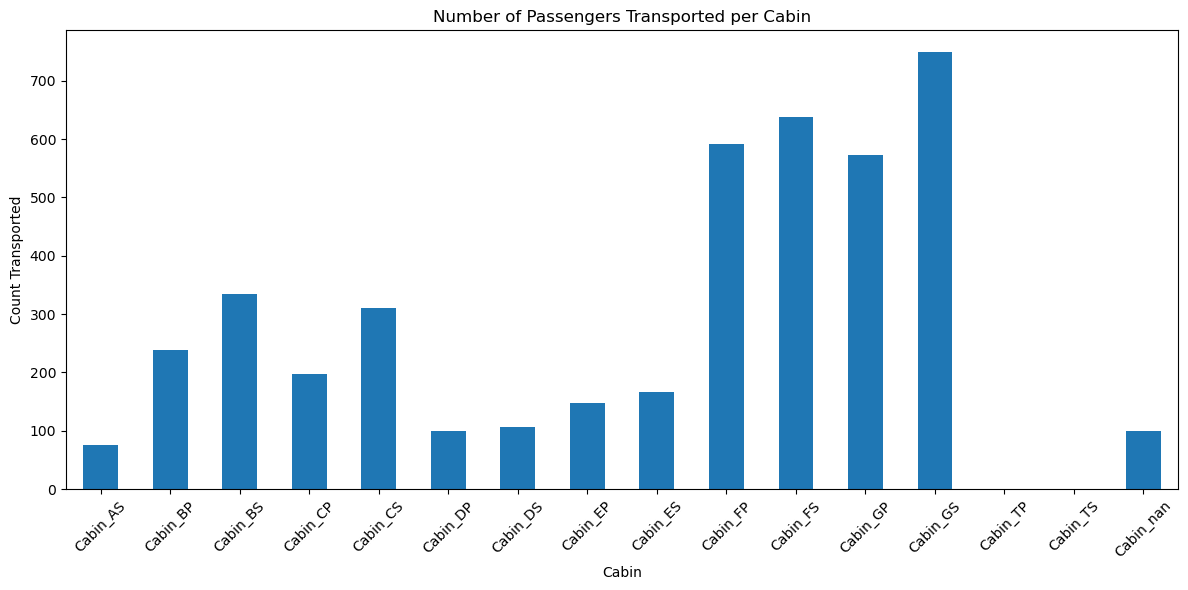

In [11]:
# Filter only rows where Transported == True
transported_true = train_df[train_df['Transported'] == True]

# Select cabin columns (those starting with 'Cabin_')
cabin_cols = [col for col in train_df.columns if col.startswith('Cabin_')]

# Sum the transported True counts per cabin
transported_counts = transported_true[cabin_cols].sum()

# Plot bar chart
plt.figure(figsize=(12,6))
transported_counts.plot(kind='bar')
plt.title('Number of Passengers Transported per Cabin')
plt.xlabel('Cabin')
plt.ylabel('Count Transported')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


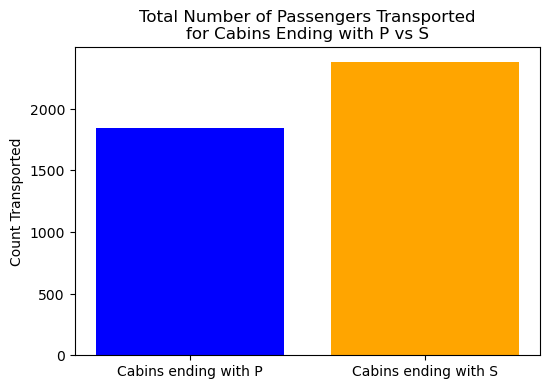

In [12]:
transported_true = train_df[train_df['Transported'] == True]

p_cols = [col for col in train_df.columns if col.startswith('Cabin_') and col.endswith('P')]
p_sum = transported_true[p_cols].sum().sum()  # sum twice: per column, then total

# Get cabin columns ending with 'S' and sum across them
s_cols = [col for col in train_df.columns if col.startswith('Cabin_') and col.endswith('S')]
s_sum = transported_true[s_cols].sum().sum()

# Prepare data for bar plot
counts = {'Cabins ending with P': p_sum, 'Cabins ending with S': s_sum}

# Plot
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
plt.title('Total Number of Passengers Transported\nfor Cabins Ending with P vs S')
plt.ylabel('Count Transported')
plt.show()

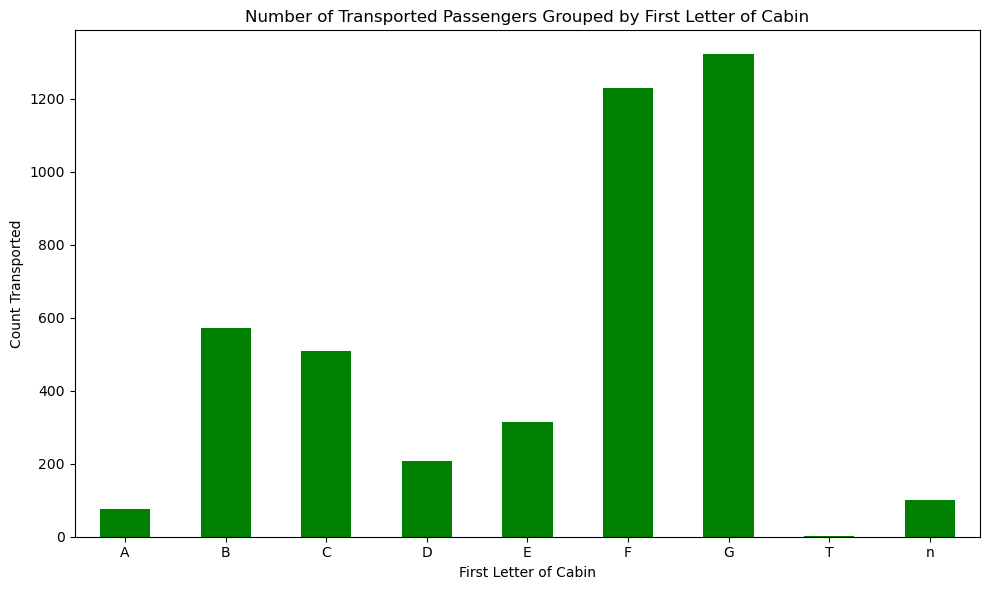

In [13]:
transported_true = train_df[train_df['Transported'] == True]

# Select cabin columns (those starting with 'Cabin_')
cabin_cols = [col for col in train_df.columns if col.startswith('Cabin_')]

# Extract the first letter after 'Cabin_' for each column
# Example: 'Cabin_AS' -> 'A', 'Cabin_BP' -> 'B'
first_letters = [col.split('_')[1][0] for col in cabin_cols]

# Create a DataFrame to help aggregate sums by first letter
encoded_sub = transported_true[cabin_cols]

# Add a row-wise sum per column grouped by the first letter
import pandas as pd
df_letters = pd.DataFrame({
    'col': cabin_cols,
    'first_letter': first_letters
})

# Sum transported counts per cabin column
sums_per_col = encoded_sub.sum()

# Merge sums with their first letters
df_letters['sum'] = df_letters['col'].map(sums_per_col)

# Group by first letter and sum the transported counts
grouped = df_letters.groupby('first_letter')['sum'].sum().sort_index()

# Plot
plt.figure(figsize=(10,6))
grouped.plot(kind='bar', color='green')
plt.title('Number of Transported Passengers Grouped by First Letter of Cabin')
plt.xlabel('First Letter of Cabin')
plt.ylabel('Count Transported')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


most of the variation comes from the cabin not from the side or number

In [14]:
selected_cols = ['Transported', 'Name']

len_df = train_df[selected_cols].copy()

In [15]:
len_df = len_df.dropna(subset=['Name'])
len_df['Name'] = len_df['Name'].str.len().astype(int)
min_length = len_df['Name'].min()
max_length = len_df['Name'].max()

print(f"Minimum name length: {min_length}")
print(f"Maximum name length: {max_length}")

Minimum name length: 7
Maximum name length: 18


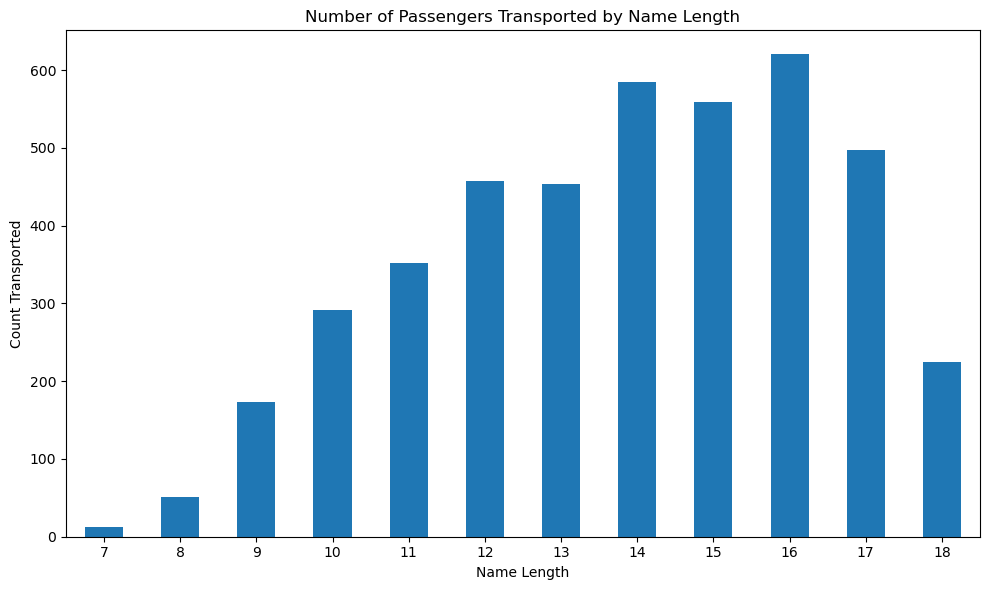

In [16]:
transported_true = len_df[len_df['Transported'] == True]
# Group by NameLength and count number of transported passengers per length
transported_counts = transported_true.groupby('Name').size()

# To ensure all lengths from 7 to 18 appear in the plot, reindex with full range
full_range = range(7, 19)  # 7 to 18 inclusive
transported_counts = transported_counts.reindex(full_range, fill_value=0)

# Plot bar chart
plt.figure(figsize=(10,6))
transported_counts.plot(kind='bar')
plt.title('Number of Passengers Transported by Name Length')
plt.xlabel('Name Length')
plt.ylabel('Count Transported')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
train_df = pd.read_csv('train.csv')

train_df['Name'] = train_df['Name'].str.len()
train_df['total spending'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
train_df['Cabin'] = train_df['Cabin'].str[0] + train_df['Cabin'].str[-1]
train_df['VIP'] = train_df['VIP'].fillna(False).astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].fillna(False).astype(int)

categorical_features = ['HomePlanet','Cabin','Destination']
for col in categorical_features:
    train_df[col] = train_df[col].fillna('Missing')

numeric_cols = train_df.select_dtypes(include='number').columns
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
# Define the column transformer:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass other columns unchanged
)

X_processed = preprocessor.fit_transform(train_df).astype(float)

In [18]:
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Get the passthrough columns (all except categorical_features)
passthrough_cols = [col for col in train_df.columns if col not in categorical_features]

# Combine feature names for the full DataFrame
all_feature_names = list(cat_feature_names) + passthrough_cols

X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names, index=train_df.index)

print(X_processed_df.head())

   HomePlanet_Europa  HomePlanet_Mars  HomePlanet_Missing  Cabin_AS  Cabin_BP  \
0                1.0              0.0                 0.0       0.0       1.0   
1                0.0              0.0                 0.0       0.0       0.0   
2                1.0              0.0                 0.0       1.0       0.0   
3                1.0              0.0                 0.0       1.0       0.0   
4                0.0              0.0                 0.0       0.0       0.0   

   Cabin_BS  Cabin_CP  Cabin_CS  Cabin_DP  Cabin_DS  ...   Age  VIP  \
0       0.0       0.0       0.0       0.0       0.0  ...  39.0  0.0   
1       0.0       0.0       0.0       0.0       0.0  ...  24.0  0.0   
2       0.0       0.0       0.0       0.0       0.0  ...  58.0  1.0   
3       0.0       0.0       0.0       0.0       0.0  ...  33.0  0.0   
4       0.0       0.0       0.0       0.0       0.0  ...  16.0  0.0   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Name  Transported  \
0       

In [19]:
X_processed_df.columns

Index(['HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Missing',
       'Cabin_AS', 'Cabin_BP', 'Cabin_BS', 'Cabin_CP', 'Cabin_CS', 'Cabin_DP',
       'Cabin_DS', 'Cabin_EP', 'Cabin_ES', 'Cabin_FP', 'Cabin_FS', 'Cabin_GP',
       'Cabin_GS', 'Cabin_Missing', 'Cabin_TP', 'Cabin_TS',
       'Destination_Missing', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'PassengerId', 'CryoSleep', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'total spending'],
      dtype='object')

In [20]:
X_df = X_processed_df.drop(columns = ['PassengerId', 'Transported'])


In [21]:
sc = StandardScaler()
X_df_std = sc.fit_transform(X_df)

In [22]:

pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_df_std)
pca.explained_variance_ratio_
egan_vecs= pca.components_
egan_vals = pca.explained_variance_
print(len(egan_vals))

32


In [23]:
loadings = egan_vecs * np.sqrt(egan_vals)


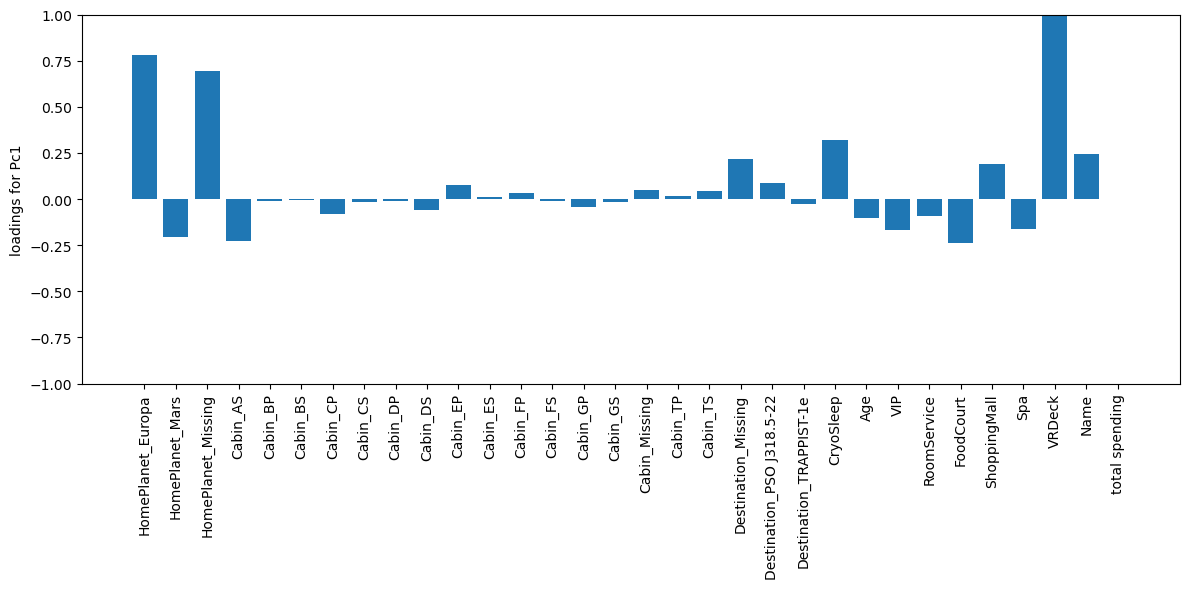

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(32), loadings[:,0], align='center')
ax.set_ylabel('loadings for Pc1')
ax.set_xticks(range(32))
ax.set_xticklabels(X_df.columns, rotation=90)
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

In [25]:
from scipy.stats import pearsonr, chi2_contingency


target_col = "Transported"

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))


for col in X_processed_df.columns:
    if col == target_col:
        continue

    pearson_corr, pearson_p = pearsonr(X_processed_df[col], X_processed_df[target_col])

    # Chi-square & Cramér's V
    contingency = pd.crosstab(X_processed_df[col], X_processed_df[target_col])
    chi2_stat, chi2_p, _, _ = chi2_contingency(contingency)
    cramers_v_val = cramers_v(contingency)
    print(f"******* COLUMN: {col} *******")
    print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.4g})")
    print(f"Chi-square: {chi2_stat:.4f} (p={chi2_p:.4g})")
    print(f"Cramér's V: {cramers_v_val:.4f}")



******* COLUMN: HomePlanet_Europa *******
Pearson correlation: 0.1769 (p=4.675e-62)
Chi-square: 271.2641 (p=6.017e-61)
Cramér's V: 0.1766
******* COLUMN: HomePlanet_Mars *******
Pearson correlation: 0.0195 (p=0.06844)
Chi-square: 3.2237 (p=0.07258)
Cramér's V: 0.0193
******* COLUMN: HomePlanet_Missing *******
Pearson correlation: 0.0027 (p=0.8004)
Chi-square: 0.0329 (p=0.856)
Cramér's V: 0.0019
******* COLUMN: Cabin_AS *******
Pearson correlation: 0.0110 (p=0.3052)
Chi-square: 0.8835 (p=0.3472)
Cramér's V: 0.0101
******* COLUMN: Cabin_BP *******
Pearson correlation: 0.0702 (p=5.676e-11)
Chi-square: 42.1273 (p=8.552e-11)
Cramér's V: 0.0696
******* COLUMN: Cabin_BS *******
Pearson correlation: 0.1273 (p=9.655e-33)
Chi-square: 139.7237 (p=3.059e-32)
Cramér's V: 0.1268
******* COLUMN: Cabin_CP *******
Pearson correlation: 0.0311 (p=0.003703)
Chi-square: 8.1049 (p=0.004415)
Cramér's V: 0.0305
******* COLUMN: Cabin_CS *******
Pearson correlation: 0.1151 (p=5.167e-27)
Chi-square: 114.0108 (p=

In [26]:
train_df['Cabin']

0       BP
1       FS
2       AS
3       AS
4       FS
        ..
8688    AP
8689    GS
8690    GS
8691    ES
8692    ES
Name: Cabin, Length: 8693, dtype: object

In [27]:
metrics = []

for col in X_processed_df.columns:
    if col == target_col:
        continue
    pearson_corr, pearson_p = pearsonr(X_processed_df[col], X_processed_df[target_col])

    # Chi-square & Cramér's V
    contingency = pd.crosstab(X_processed_df[col], X_processed_df[target_col])
    chi2_stat, chi2_p, _, _ = chi2_contingency(contingency)
    cramers_v_val = cramers_v(contingency)
    metrics.append((col,pearson_corr,pearson_p, cramers_v_val))
    

metrics.sort(key=lambda x: abs(x[1]), reverse=True)
for m in metrics:
    print(f"{m[0]} | Pearson: {m[1]:.4f} | Cramér's V: {m[3]:.4f}")

CryoSleep | Pearson: 0.4601 | Cramér's V: 0.4599
RoomService | Pearson: -0.2411 | Cramér's V: 0.4720
Spa | Pearson: -0.2185 | Cramér's V: 0.4755
VRDeck | Pearson: -0.2049 | Cramér's V: 0.4587
total spending | Pearson: -0.1995 | Cramér's V: 0.6927
HomePlanet_Europa | Pearson: 0.1769 | Cramér's V: 0.1766
Cabin_BS | Pearson: 0.1273 | Cramér's V: 0.1268
Cabin_CS | Pearson: 0.1151 | Cramér's V: 0.1145
Destination_TRAPPIST-1e | Pearson: -0.0947 | Cramér's V: 0.0945
Cabin_FP | Pearson: -0.0825 | Cramér's V: 0.0822
Age | Pearson: -0.0742 | Cramér's V: 0.1726
Cabin_EP | Pearson: -0.0734 | Cramér's V: 0.0728
Cabin_BP | Pearson: 0.0702 | Cramér's V: 0.0696
Cabin_GS | Pearson: 0.0667 | Cramér's V: 0.0664
Cabin_ES | Pearson: -0.0616 | Cramér's V: 0.0611
Cabin_GP | Pearson: -0.0459 | Cramér's V: 0.0456
FoodCourt | Pearson: 0.0456 | Cramér's V: 0.4905
VIP | Pearson: -0.0373 | Cramér's V: 0.0365
Cabin_DP | Pearson: -0.0344 | Cramér's V: 0.0337
Cabin_CP | Pearson: 0.0311 | Cramér's V: 0.0305
Cabin_FS |

In [28]:
contingency = pd.crosstab(train_df['Cabin'], train_df[target_col])
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency)
cramers_v_val = cramers_v(contingency)
print(f"Cabin (grouped) Chi2: {chi2_stat}, p={chi2_p}, Cramér's V: {cramers_v_val}")


Cabin (grouped) Chi2: 489.16477699718087, p=6.431637873802997e-94, Cramér's V: 0.23721532843357568


In [29]:
transported_counts = train_df[train_df['Transported'] == True].groupby('Cabin').size()
sorted_cabins = transported_counts.sort_values(ascending=False).index
cabin_mapping = {cabin: rank for rank, cabin in enumerate(sorted_cabins)}
train_df['Cabin_ordinal'] = train_df['Cabin'].map(cabin_mapping).fillna(-1).astype(int)
train_df['Cabin_ordinal']

0        6
1        1
2       13
3       13
4        1
        ..
8688    14
8689     0
8690     0
8691     8
8692     8
Name: Cabin_ordinal, Length: 8693, dtype: int64

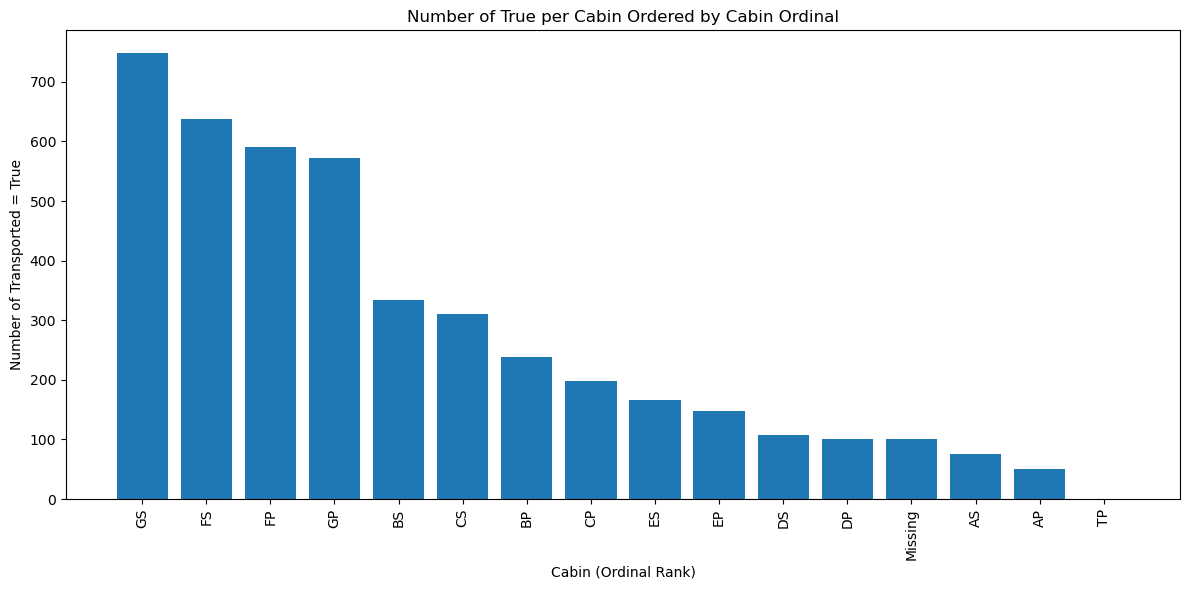

Cabin
GS         749
FS         638
FP         591
GP         572
BS         334
CS         310
BP         238
CP         198
ES         166
EP         147
DS         107
DP         100
Missing    100
AS          76
AP          51
TP           1
dtype: int64


In [30]:
counts_df = transported_counts.reset_index()
counts_df.columns = ['Cabin', 'True_Count']

# Add the rank from cabin_mapping
counts_df['Rank'] = counts_df['Cabin'].map(cabin_mapping)

# Sort by Rank to plot in order of ordinal mapping
counts_df = counts_df.sort_values('Rank')

# Plot
plt.figure(figsize=(12,6))
plt.bar(counts_df['Rank'], counts_df['True_Count'], tick_label=counts_df['Cabin'])
plt.xlabel('Cabin (Ordinal Rank)')
plt.ylabel('Number of Transported = True')
plt.title('Number of True per Cabin Ordered by Cabin Ordinal')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
print(transported_counts.sort_values(ascending=False))


In [31]:
contingency = pd.crosstab(train_df['Cabin_ordinal'], train_df[target_col])
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency)
cramers_v_val = cramers_v(contingency)
print(f"Cabin (grouped) Chi2: {chi2_stat}, p={chi2_p}, Cramér's V: {cramers_v_val}")


Cabin (grouped) Chi2: 489.1647769971808, p=6.431637873803183e-94, Cramér's V: 0.23721532843357565


In [32]:
def test_values(y_pred, y_test):
    y_pred = np.array(y_pred)

    # ✅ If shape is (n_samples, 1), flatten it to (n_samples,)
    if y_pred.ndim > 1:
        y_pred = y_pred.ravel()

    # ✅ Only threshold if values are probabilities (i.e. float)
    if y_pred.dtype != int and y_pred.dtype != np.int64:
        y_pred = (y_pred >= 0.5).astype(int)

    np_y_test = np.array(y_test)
    print(np.unique(np_y_test), np_y_test.dtype)
    print(np.unique(y_pred), y_pred.dtype)


    acc = accuracy_score(np_y_test, y_pred)
    prec = precision_score(np_y_test, y_pred)
    rec = recall_score(np_y_test, y_pred)
    f1 = f1_score(np_y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(np_y_test, y_pred))

In [33]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'total spending', 'Cabin_ordinal'],
      dtype='object')

In [38]:
X = train_df[['Cabin_ordinal','Name', 'total spending']]
y = train_df['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_values(y_pred, y_test)

[False  True] bool
[0 1] int64

Accuracy: 0.6224
Precision: 0.5877
Recall: 0.8384
F1 Score: 0.6910
Confusion Matrix:
 [[435 644]
 [177 918]]


In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
pc = PCA(n_components=15)

target = train_df['Transported']
X_train, X_test, y_train, y_test = train_test_split(X_df_std, target, stratify=target, test_size=0.1, random_state=42, shuffle=True)
gbc = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=5, min_samples_split=3,
        min_samples_leaf=2, subsample=0.8, max_features='sqrt', random_state=42)


In [36]:
#PCA used
X_train_pc = pc.fit_transform(X_train)
X_test_pc = pc.transform(X_test)
gbc.fit(X_train_pc, y_train)
y_pred_pc = gbc.predict(X_test_pc)
print("\nResults with PCA features:")
test_values(y_test, y_pred_pc)



Results with PCA features:
[False  True] bool
[0 1] int64

Accuracy: 0.7874
Precision: 0.7557
Recall: 0.8093
F1 Score: 0.7816
Confusion Matrix:
 [[354 107]
 [ 78 331]]


In [37]:
# LDA used
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
gbc.fit(X_train_lda, y_train)
y_pred_lda = gbc.predict(X_test_lda)
print("Results with LDA features:")
test_values(y_test, y_pred_lda)

Results with LDA features:
[False  True] bool
[0 1] int64

Accuracy: 0.7552
Precision: 0.7648
Recall: 0.7528
F1 Score: 0.7588
Confusion Matrix:
 [[322 103]
 [110 335]]
